In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
import h5py

2022-07-08 00:17:38.707332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 00:17:38.707351: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-08 00:17:39.700887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-08 00:17:39.700908: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-08 00:17:39.700923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-07-08 00:17:39.701137: I tensorflow/core/platform/cpu_fe

In [2]:
f = h5py.File("data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")
f2 = h5py.File("data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")
#f3 = h5py.File("data/quark-gluon/quark-gluon_test-set_n139306.hdf5","r")

In [3]:
x_train = f.get('X_jets')

In [4]:
y_train = f.get('y')

In [5]:
x_train

<HDF5 dataset "X_jets": shape (793900, 125, 125, 3), type "<f4">

In [6]:
x_train.shape

(793900, 125, 125, 3)

In [7]:
793900 // 2300

345

In [8]:
import keras
import numpy as np
from tensorflow.keras.utils import Sequence

In [9]:
class Generator(Sequence) :
  
  def __init__(self, hdf5_file, batch_size) :
    self.hdf5_file = hdf5_file
    self.batch_size = batch_size
    
  # Länge der Trainingsdaten (Anzahl der Batches)
  def __len__(self) :
    return x_train.shape[0]//self.batch_size
  
  # Lädt Bilder anhand der Pfade aus dem Trainingsarray
  def __getitem__(self, idx) :
    
    return self.hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size], self.hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size]

In [10]:
traingen = Generator(x_train, 900)

In [11]:
model = cae.Convolutional_Autoencoder2(6)

In [12]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 42, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 16)        1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 6)                 9606      
                                                                 
Total params: 34,134
Trainable params: 34,134
Non-traina

In [13]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.05))

/usr/local/lib/python3.9/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
hist = model.fit_generator(traingen,epochs=2)

/tmp/ipykernel_314042/565034597.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(traingen,epochs=2)


Epoch 1/2
882/882 [==============================] - 4956s 6s/step - loss: 0.0012
Epoch 2/2
882/882 [==============================] - 5067s 6s/step - loss: 2.1277e-04


In [15]:
x_test = f2.get('X')
y_test = f2.get('y')

In [16]:
x_test.shape

(10000, 125, 125, 3)

In [17]:
def mae(x):
    pred = model.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=(1,2,3))

def recon_acc(x):
    return 1 - mae(x)

In [18]:
x_test[:2000].shape

(2000, 125, 125, 3)

In [19]:
x_test[8000:10000].shape

(2000, 125, 125, 3)

In [20]:
zerrooo = recon_acc(x_test[:2000])
one = recon_acc(x_test[8000:10000])

In [21]:
zerrooo.shape

(2000,)

0.9999977
0.99999565


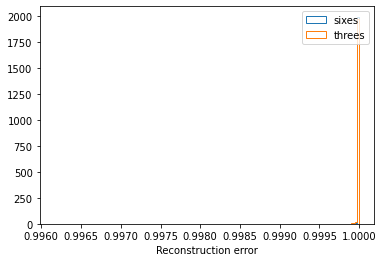

In [31]:
print(np.median(zerrooo))
bins = np.histogram(np.hstack((zerrooo, one)), bins=150)[1]
plt.hist(zerrooo, histtype='step', label="sixes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(one))
plt.hist(one, histtype='step', label="threes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.xlabel("Reconstruction error")
plt.legend()

In [23]:
x_train.shape[0]

793900

In [24]:
batch_size = 1700

In [25]:
num_batches = x_train.shape[0]/batch_size

In [28]:
fsmall.close()

In [27]:
fsmall = h5py.File('../../data/compressed2.hdf5','w')
fsmall.create_dataset('X', shape=(x_train.shape[0],6))
fsmall.create_dataset('y', shape=(x_train.shape[0], 1))

for i in range(int(num_batches)):
    fsmall['X'][i * batch_size: (i + 1) * batch_size] = model.encoder(x_train[i * batch_size: (i + 1) * batch_size])
    fsmall['y'][i * batch_size: (i + 1) * batch_size] = y_train[i * batch_size: (i + 1) * batch_size].reshape((batch_size,1))
    print(i, end="\r")

In [37]:
model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1600)              11200     
                                                                 
 reshape (Reshape)           (None, 5, 5, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 15, 15, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 31, 31, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 62, 62, 16)       4624      
 ranspose)                                                       
                                                      

In [38]:
from tensorflow.keras import layers, losses

In [39]:
x = layers.Input(shape=(6,))

In [55]:
import sympy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
import tensorflow.keras as keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

encoder = tf.keras.Sequential([
    layers.Input(shape=(6,))])

## from tensorflow.keras.models import Model
newmodel = Model(inputs=x, outputs=model.decoder)

['__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_inferred_value',
 '_keras_history',
 '_name',
 '_overload_all_operators',
 '_overload_operator',
 '_to_placeholder',
 '_type_spec',
 'dtype',
 'experimental_ref',
 'from_tensor',
 'from_ty

In [54]:
model.decoder(np.array([1,1,1,1,1,1]))

ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).

Input 0 of layer "dense_1" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (6,)

Call arguments received:
  • inputs=tf.Tensor(shape=(6,), dtype=int64)
  • training=None
  • mask=None